# Similarity Distribution Analysis: Multi-Vector HNSW+SQ8

Analyzing pairwise cosine similarity distributions for the **multi-vector** strategy with **HNSW+SQ8** index.

Three analysis approaches:
1. Random pair sampling
2. Anchor-based sampling
3. Nearest-neighbor distribution

In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import torch

# Configuration
STRATEGY = "multi-vector"
INDEX_TYPE = "hnsw_sq8"
INDEX_PATH = Path("../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.faiss")
METADATA_PATH = Path("../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.metadata.json")

# Check GPU availability
USE_GPU = torch.cuda.is_available()
print(f"GPU available: {USE_GPU}")
if USE_GPU:
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU device: NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Load Index and Extract Vectors

In [2]:
# Load FAISS index
print(f"Loading index from {INDEX_PATH}...")
index = faiss.read_index(str(INDEX_PATH))
n_vectors = index.ntotal
dim = index.d
print(f"Index loaded: {n_vectors:,} vectors, dimension {dim}")

# Load metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)
print(f"Metadata loaded: {len(metadata):,} entries")

Loading index from ../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.faiss...
Index loaded: 1,749,141 vectors, dimension 384
Metadata loaded: 1,749,141 entries


In [ ]:
# Extract vectors from the index
# For HNSW+SQ8, we need to reconstruct vectors
print("Reconstructing vectors from index (batch mode)...")

# Use batch reconstruction for better performance
vectors = np.zeros((n_vectors, dim), dtype=np.float32)
index.reconstruct_n(0, n_vectors, vectors)

# Normalize vectors (should already be normalized, but ensure)
norms = np.linalg.norm(vectors, axis=1, keepdims=True)
vectors = vectors / np.clip(norms, 1e-8, None)

print(f"Vectors reconstructed: shape {vectors.shape}")

## 2. Random Pair Sampling

Sample 100K random pairs of vectors and compute their cosine similarity.

In [4]:
N_PAIRS = 100_000

# Sample random pairs
np.random.seed(42)
idx1 = np.random.randint(0, n_vectors, size=N_PAIRS)
idx2 = np.random.randint(0, n_vectors, size=N_PAIRS)

# Ensure no self-pairs
same_mask = idx1 == idx2
idx2[same_mask] = (idx2[same_mask] + 1) % n_vectors

print(f"Sampled {N_PAIRS:,} random pairs")

Sampled 100,000 random pairs


In [5]:
# Compute cosine similarities using GPU if available
if USE_GPU:
    print("Computing similarities on GPU...")
    v1 = torch.tensor(vectors[idx1], device='cuda')
    v2 = torch.tensor(vectors[idx2], device='cuda')
    random_pair_similarities = (v1 * v2).sum(dim=1).cpu().numpy()
    del v1, v2
    torch.cuda.empty_cache()
else:
    print("Computing similarities on CPU...")
    random_pair_similarities = np.sum(vectors[idx1] * vectors[idx2], axis=1)

print(f"Computed {len(random_pair_similarities):,} similarities")
print(f"Mean: {random_pair_similarities.mean():.4f}")
print(f"Std: {random_pair_similarities.std():.4f}")
print(f"Min: {random_pair_similarities.min():.4f}")
print(f"Max: {random_pair_similarities.max():.4f}")

Computing similarities on GPU...
Computed 100,000 similarities
Mean: 0.3208
Std: 0.2124
Min: -0.1197
Max: 1.0000


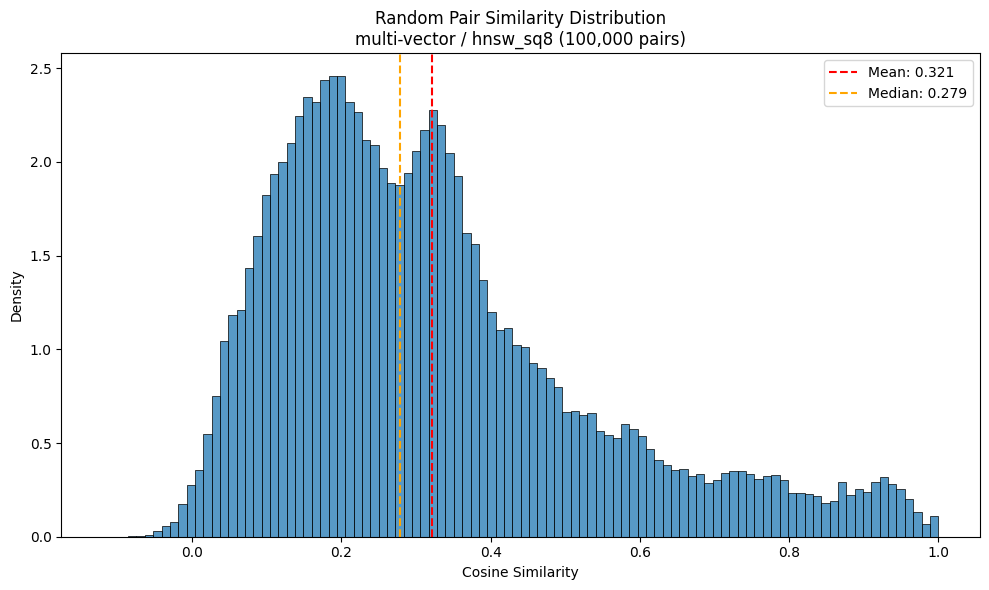


Percentiles:
  1th: 0.0118
  5th: 0.0590
  25th: 0.1654
  50th: 0.2789
  75th: 0.4187
  95th: 0.7806
  99th: 0.9391


In [6]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(random_pair_similarities, bins=100, ax=ax, stat='density')
ax.axvline(random_pair_similarities.mean(), color='red', linestyle='--', label=f'Mean: {random_pair_similarities.mean():.3f}')
ax.axvline(np.median(random_pair_similarities), color='orange', linestyle='--', label=f'Median: {np.median(random_pair_similarities):.3f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title(f'Random Pair Similarity Distribution\n{STRATEGY} / {INDEX_TYPE} ({N_PAIRS:,} pairs)')
ax.legend()
plt.tight_layout()
plt.show()

# Percentiles
percentiles = [1, 5, 25, 50, 75, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"  {p}th: {np.percentile(random_pair_similarities, p):.4f}")

## 3. Anchor-Based Sampling

Select 1000 anchor vectors, compute similarity to 100 random others for each.

In [7]:
N_ANCHORS = 1000
N_OTHERS = 100

np.random.seed(43)
anchor_indices = np.random.choice(n_vectors, size=N_ANCHORS, replace=False)
anchor_similarities = []

print(f"Computing anchor-based similarities ({N_ANCHORS} anchors x {N_OTHERS} others)...")

if USE_GPU:
    anchors_gpu = torch.tensor(vectors[anchor_indices], device='cuda')
    for i, anchor_idx in enumerate(anchor_indices):
        # Sample N_OTHERS random indices (excluding anchor)
        others = np.random.choice(np.delete(np.arange(n_vectors), anchor_idx), size=N_OTHERS, replace=False)
        others_gpu = torch.tensor(vectors[others], device='cuda')
        sims = (anchors_gpu[i:i+1] * others_gpu).sum(dim=1).cpu().numpy()
        anchor_similarities.extend(sims)
    del anchors_gpu, others_gpu
    torch.cuda.empty_cache()
else:
    for anchor_idx in anchor_indices:
        others = np.random.choice(np.delete(np.arange(n_vectors), anchor_idx), size=N_OTHERS, replace=False)
        sims = np.dot(vectors[others], vectors[anchor_idx])
        anchor_similarities.extend(sims)

anchor_similarities = np.array(anchor_similarities)
print(f"Computed {len(anchor_similarities):,} similarities")

Computing anchor-based similarities (1000 anchors x 100 others)...
Computed 100,000 similarities


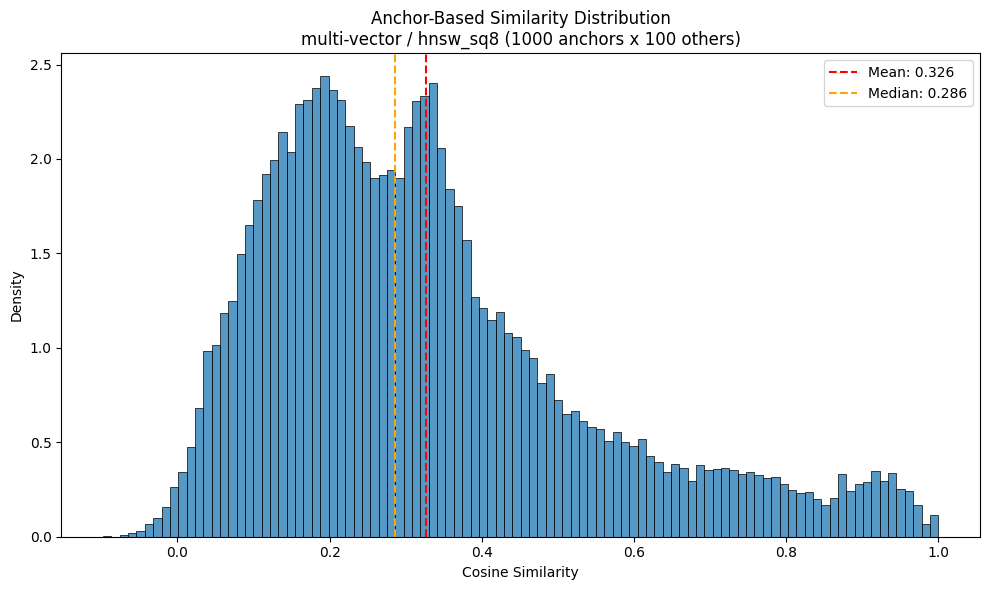


Stats:
Mean: 0.3261
Std: 0.2145


In [8]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(anchor_similarities, bins=100, ax=ax, stat='density')
ax.axvline(anchor_similarities.mean(), color='red', linestyle='--', label=f'Mean: {anchor_similarities.mean():.3f}')
ax.axvline(np.median(anchor_similarities), color='orange', linestyle='--', label=f'Median: {np.median(anchor_similarities):.3f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title(f'Anchor-Based Similarity Distribution\n{STRATEGY} / {INDEX_TYPE} ({N_ANCHORS} anchors x {N_OTHERS} others)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nStats:")
print(f"Mean: {anchor_similarities.mean():.4f}")
print(f"Std: {anchor_similarities.std():.4f}")

## 4. Nearest-Neighbor Distribution

Use FAISS to find top-K neighbors for random query vectors. This shows how "tight" clusters are.

In [9]:
N_QUERIES = 1000
K_NEIGHBORS = 50

np.random.seed(44)
query_indices = np.random.choice(n_vectors, size=N_QUERIES, replace=False)
query_vectors = vectors[query_indices]

print(f"Searching for {K_NEIGHBORS} nearest neighbors for {N_QUERIES} queries...")

# Search for neighbors
distances, indices = index.search(query_vectors, K_NEIGHBORS + 1)  # +1 to exclude self

# Remove self-matches (first result is usually the query itself)
raw_distances = distances[:, 1:].flatten()  # Skip first column (self)

# =============================================================================
# IMPORTANT FIX: Converting FAISS L2² distances to cosine similarity
# =============================================================================
# FAISS HNSW+SQ8 (and IVF+SQ8) indices use L2 metric by default and return
# SQUARED L2 distances (L2²), not cosine similarities or regular L2.
#
# For normalized vectors (unit length), the relationship is:
#   L2² = ||a - b||² = ||a||² + ||b||² - 2(a·b) = 1 + 1 - 2*cos(θ) = 2(1 - cos(θ))
#
# Therefore, to convert L2² to cosine similarity:
#   cos(θ) = 1 - L2²/2
#
# BUG THAT WAS FIXED: Originally we incorrectly squared the distances again,
# using `1 - (raw_distances ** 2) / 2`, which produced invalid values > 1.
# The correct formula is simply `1 - raw_distances / 2` since FAISS already
# returns squared distances.
# =============================================================================
nn_similarities = 1 - raw_distances / 2

# Clip to [-1, 1] range (quantization noise can cause slight overflow)
nn_similarities = np.clip(nn_similarities, -1.0, 1.0)

print(f"Found {len(nn_similarities):,} neighbor similarities")
print(f"Raw L2² distances - Min: {raw_distances.min():.4f}, Max: {raw_distances.max():.4f}")
print(f"Converted cosine similarities - Min: {nn_similarities.min():.4f}, Max: {nn_similarities.max():.4f}")

Searching for 50 nearest neighbors for 1000 queries...
Found 50,000 neighbor similarities
Raw L2² distances - Min: 0.0000, Max: 1.4702
Converted cosine similarities - Min: 0.2649, Max: 1.0000


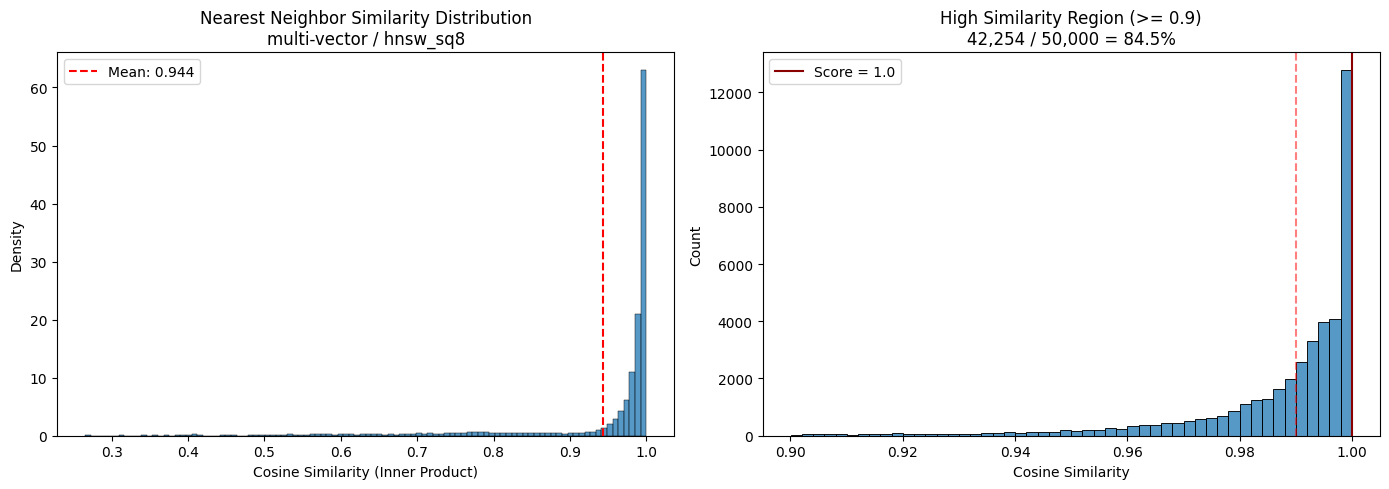

In [10]:
# Plot histogram with special attention to score=1.0 (identical vectors)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
ax = axes[0]
sns.histplot(nn_similarities, bins=100, ax=ax, stat='density')
ax.axvline(nn_similarities.mean(), color='red', linestyle='--', label=f'Mean: {nn_similarities.mean():.3f}')
ax.set_xlabel('Cosine Similarity (Inner Product)')
ax.set_ylabel('Density')
ax.set_title(f'Nearest Neighbor Similarity Distribution\n{STRATEGY} / {INDEX_TYPE}')
ax.legend()

# Zoom in on high similarity region (0.9 - 1.0)
ax = axes[1]
high_sim = nn_similarities[nn_similarities >= 0.9]
sns.histplot(high_sim, bins=50, ax=ax, stat='count')
ax.axvline(0.99, color='red', linestyle='--', alpha=0.5)
ax.axvline(1.0, color='darkred', linestyle='-', label='Score = 1.0')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title(f'High Similarity Region (>= 0.9)\n{len(high_sim):,} / {len(nn_similarities):,} = {100*len(high_sim)/len(nn_similarities):.1f}%')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Analyze identical/near-identical vectors
identical_count = np.sum(nn_similarities >= 0.9999)
near_identical_count = np.sum(nn_similarities >= 0.99)
high_sim_count = np.sum(nn_similarities >= 0.9)

print("Nearest Neighbor Analysis:")
print(f"  Total neighbor pairs: {len(nn_similarities):,}")
print(f"  Identical (>= 0.9999): {identical_count:,} ({100*identical_count/len(nn_similarities):.2f}%)")
print(f"  Near-identical (>= 0.99): {near_identical_count:,} ({100*near_identical_count/len(nn_similarities):.2f}%)")
print(f"  High similarity (>= 0.9): {high_sim_count:,} ({100*high_sim_count/len(nn_similarities):.2f}%)")
print(f"\nDistribution stats:")
print(f"  Mean: {nn_similarities.mean():.4f}")
print(f"  Median: {np.median(nn_similarities):.4f}")
print(f"  Std: {nn_similarities.std():.4f}")
print(f"  Min: {nn_similarities.min():.4f}")
print(f"  Max: {nn_similarities.max():.4f}")

Nearest Neighbor Analysis:
  Total neighbor pairs: 50,000
  Identical (>= 0.9999): 10,607 (21.21%)
  Near-identical (>= 0.99): 26,720 (53.44%)
  High similarity (>= 0.9): 42,254 (84.51%)

Distribution stats:
  Mean: 0.9437
  Median: 0.9914
  Std: 0.1179
  Min: 0.2649
  Max: 1.0000


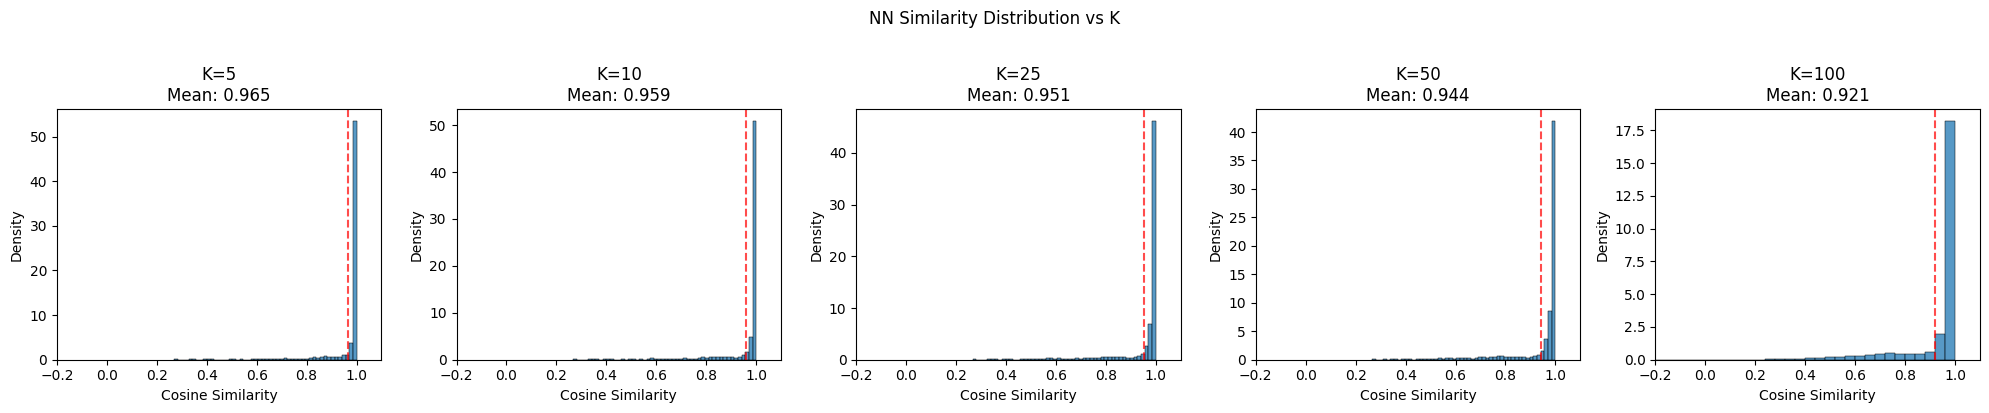


Summary by K:
    K |     Mean |   Median |   % >= 0.9 |  % >= 0.99
-------------------------------------------------------
    5 |   0.9645 |   0.9972 |     89.06% |     74.10%
   10 |   0.9591 |   0.9960 |     87.42% |     68.57%
   25 |   0.9509 |   0.9937 |     85.72% |     60.28%
   50 |   0.9437 |   0.9914 |     84.51% |     53.44%
  100 |   0.9207 |   0.9874 |     82.22% |     44.53%


In [12]:
# =============================================================================
# Explore how K affects the NN similarity distribution
# =============================================================================
# Question from Andrew: does the peak shift towards 1 with smaller K?
# 
# Expected behavior: With smaller K, we only look at the closest neighbors,
# so the mean similarity should be higher (peak closer to 1.0).
# With larger K, we include more distant neighbors, lowering the mean.
#
# Same L2² -> cosine conversion as above: cos(θ) = 1 - L2²/2
# =============================================================================

K_values = [5, 10, 25, 50, 100]
fig, axes = plt.subplots(1, len(K_values), figsize=(20, 4))

for ax, k in zip(axes, K_values):
    # Search with this K
    dists, _ = index.search(query_vectors, k + 1)
    raw_dists = dists[:, 1:].flatten()
    # Convert L2² to cosine similarity
    sims = np.clip(1 - raw_dists / 2, -1.0, 1.0)
    
    sns.histplot(sims, bins=50, ax=ax, stat='density')
    ax.axvline(sims.mean(), color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('Cosine Similarity')
    ax.set_title(f'K={k}\nMean: {sims.mean():.3f}')
    ax.set_xlim(-0.2, 1.1)

plt.suptitle('NN Similarity Distribution vs K', y=1.02)
plt.tight_layout()
plt.show()

# Summary stats for each K
print("\nSummary by K:")
print(f"{'K':>5} | {'Mean':>8} | {'Median':>8} | {'% >= 0.9':>10} | {'% >= 0.99':>10}")
print("-" * 55)
for k in K_values:
    dists, _ = index.search(query_vectors, k + 1)
    raw_dists = dists[:, 1:].flatten()
    sims = np.clip(1 - raw_dists / 2, -1.0, 1.0)
    pct_90 = 100 * np.sum(sims >= 0.9) / len(sims)
    pct_99 = 100 * np.sum(sims >= 0.99) / len(sims)
    print(f"{k:>5} | {sims.mean():>8.4f} | {np.median(sims):>8.4f} | {pct_90:>9.2f}% | {pct_99:>9.2f}%")

## 5. Summary Comparison

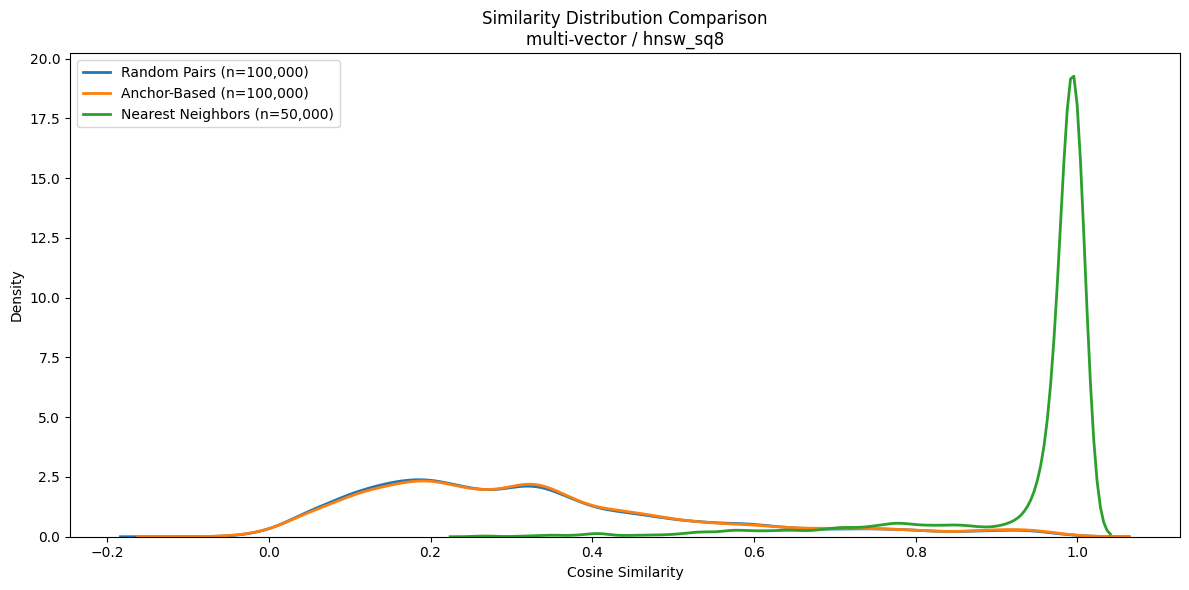

In [13]:
# Compare all three distributions
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(random_pair_similarities, ax=ax, label=f'Random Pairs (n={len(random_pair_similarities):,})', linewidth=2)
sns.kdeplot(anchor_similarities, ax=ax, label=f'Anchor-Based (n={len(anchor_similarities):,})', linewidth=2)
sns.kdeplot(nn_similarities, ax=ax, label=f'Nearest Neighbors (n={len(nn_similarities):,})', linewidth=2)

ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title(f'Similarity Distribution Comparison\n{STRATEGY} / {INDEX_TYPE}')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# Summary table
import pandas as pd

summary = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std', 'Min', 'Max', '% >= 0.9', '% >= 0.99'],
    'Random Pairs': [
        f"{random_pair_similarities.mean():.4f}",
        f"{np.median(random_pair_similarities):.4f}",
        f"{random_pair_similarities.std():.4f}",
        f"{random_pair_similarities.min():.4f}",
        f"{random_pair_similarities.max():.4f}",
        f"{100*np.sum(random_pair_similarities >= 0.9)/len(random_pair_similarities):.2f}%",
        f"{100*np.sum(random_pair_similarities >= 0.99)/len(random_pair_similarities):.2f}%"
    ],
    'Anchor-Based': [
        f"{anchor_similarities.mean():.4f}",
        f"{np.median(anchor_similarities):.4f}",
        f"{anchor_similarities.std():.4f}",
        f"{anchor_similarities.min():.4f}",
        f"{anchor_similarities.max():.4f}",
        f"{100*np.sum(anchor_similarities >= 0.9)/len(anchor_similarities):.2f}%",
        f"{100*np.sum(anchor_similarities >= 0.99)/len(anchor_similarities):.2f}%"
    ],
    'Nearest Neighbors': [
        f"{nn_similarities.mean():.4f}",
        f"{np.median(nn_similarities):.4f}",
        f"{nn_similarities.std():.4f}",
        f"{nn_similarities.min():.4f}",
        f"{nn_similarities.max():.4f}",
        f"{100*np.sum(nn_similarities >= 0.9)/len(nn_similarities):.2f}%",
        f"{100*np.sum(nn_similarities >= 0.99)/len(nn_similarities):.2f}%"
    ]
})

print(f"\n{'='*60}")
print(f"SUMMARY: {STRATEGY} / {INDEX_TYPE}")
print(f"{'='*60}")
print(summary.to_string(index=False))


SUMMARY: multi-vector / hnsw_sq8
   Metric Random Pairs Anchor-Based Nearest Neighbors
     Mean       0.3208       0.3261            0.9437
   Median       0.2789       0.2858            0.9914
      Std       0.2124       0.2145            0.1179
      Min      -0.1197      -0.0978            0.2649
      Max       1.0000       1.0000            1.0000
 % >= 0.9        2.11%        2.35%            84.51%
% >= 0.99        0.12%        0.12%            53.44%
